# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import cv2
import sklearn 
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from glob import glob
from PIL import Image
import cv2

2025-04-22 18:04:06.810057: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set seeds to make the experiment more reproducible.
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(42)

In [3]:
# Define batch size
# Training
EPOCHS = 20
BATCH_SIZE = 64
img_height = 244
img_width = 244

## Load the Datasets

In [4]:
# Load and unzip the dataset
# I had written a function which will divide the dataset as train and test (80 - 20) and using that dataset for the analysis.

data_path = 'data'
# Confirm folders are correct
class_names = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]
print("Classes:", class_names)

Classes: ['Paper', 'Food_Waste', 'Metal', 'Cardboard', 'Other', 'Glass', 'Plastic']


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [5]:
# Create a function to load the raw images
input_path = data_path


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [6]:
# Load the entire dataset without splitting
full_ds = tf.keras.utils.image_dataset_from_directory(
    input_path,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    seed=123,
    shuffle=True,
    validation_split=None # Load everything first
)

Found 7625 files belonging to 7 classes.


In [7]:
class_names = full_ds.class_names
print(class_names)

['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

2025-04-22 18:04:13.389249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


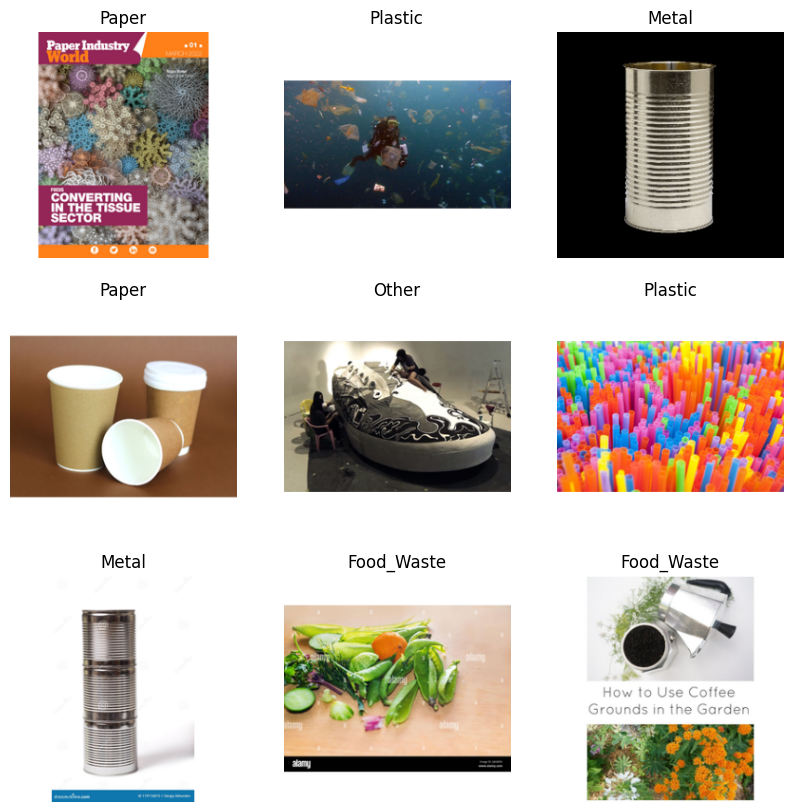

In [8]:
# Visualise Data Distribution
plt.figure(figsize=(10, 10))
for images, labels in full_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

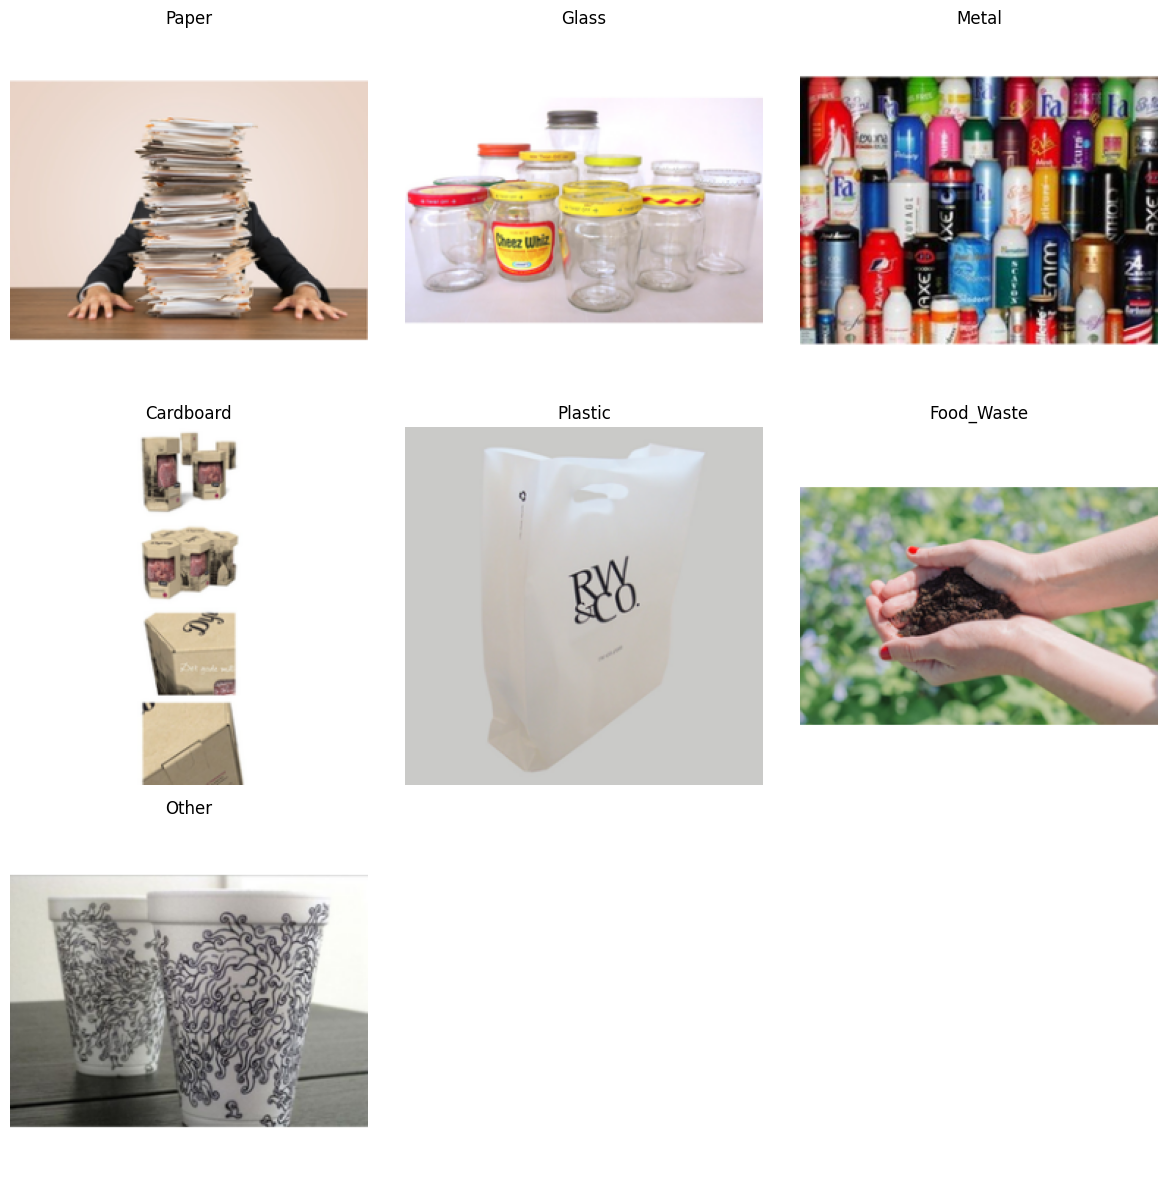

In [9]:
# Visualise Sample Images (across different labels)

import matplotlib.pyplot as plt
import numpy as np

# Assuming `full_ds` is your loaded dataset
plt.figure(figsize=(12, 12))

# Track classes already shown
shown_classes = set()

for images, labels in full_ds.take(5):  # <- use your dataset, not input_path
    batch_size = images.shape[0]
    for i in range(batch_size):
        label_index = np.argmax(labels[i].numpy())

        # Plot only if not already shown
        if label_index not in shown_classes:
            shown_classes.add(label_index)

            ax = plt.subplot(3, 3, len(shown_classes))
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[label_index])
            plt.axis("off")

        if len(shown_classes) == len(class_names):
            break  # shown all classes

    if len(shown_classes) == len(class_names):
        break

plt.tight_layout()
plt.show()




#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [10]:
# Find the smallest and largest image dimensions from the data set
import os
from PIL import Image

# Your dataset path (change if needed)
dataset_dir = input_path  # You can also check source_dir if you want original data

# Initialize min and max
min_width, min_height = float('inf'), float('inf')
max_width, max_height = 0, 0

# Walk through all class folders
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size

                    # Update min
                    if width < min_width:
                        min_width = width
                    if height < min_height:
                        min_height = height

                    # Update max
                    if width > max_width:
                        max_width = width
                    if height > max_height:
                        max_height = height
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

print(f"✅ Smallest dimensions: Width = {min_width}, Height = {min_height}")
print(f"✅ Largest dimensions: Width = {max_width}, Height = {max_height}")


✅ Smallest dimensions: Width = 256, Height = 256
✅ Largest dimensions: Width = 256, Height = 256


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [11]:
# Encode the labels suitably
import os
from sklearn.preprocessing import LabelEncoder

# Step 1: Collect all labels (folder names)
labels = []
for folder in os.listdir(input_path):
    folder_path = os.path.join(input_path, folder)
    if os.path.isdir(folder_path):
        labels.append(folder)

# Step 2: Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(labels)

# Now you can transform labels like this:
encoded_labels = label_encoder.transform(labels)

# Mapping of label to encoded integer
label_to_int = dict(zip(labels, encoded_labels))

print("✅ Encoded Labels (Integer Encoding):")
print(label_to_int)



✅ Encoded Labels (Integer Encoding):
{'Paper': 5, 'Food_Waste': 1, 'Metal': 3, 'Cardboard': 0, 'Other': 4, 'Glass': 2, 'Plastic': 6}


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [12]:
# Assign specified parts of the dataset to train and validation sets

# Get the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    input_path,
    validation_split=0.2,   # << SAME value for both
    subset='training',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    seed=123)

Found 7625 files belonging to 7 classes.
Using 6100 files for training.


In [13]:
# Get the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    input_path,
    validation_split=0.2,   # << SAME value for both
    subset='validation',
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    seed=123)

Found 7625 files belonging to 7 classes.
Using 1525 files for validation.


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

#### **SEQUENTIAL MODEL**

In [14]:
# Build and compile the model
# Build the model
model = Sequential()

# 1st Convolution Block
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution Block
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(7, activation='softmax'))  # 7 classes

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


/Users/shashidharpattar/vcs-dev/AIML_Python_Handon/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 242, 242, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 121, 121, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 121, 121, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 119, 119, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 57, 57, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,335 (49.36 MB)

 Trainable params: 12,939,335 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [15]:
# ModelCheckpoint (final corrected)
model_checkpoint = ModelCheckpoint(
    filepath='best_model.weights.h5',  
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min'
)

# ReduceLROnPlateau
rop_callback = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.000001
)


In [16]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, model_checkpoint, rop_callback]
)



Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2431 - loss: 22.3712
Epoch 1: val_loss improved from inf to 1.94396, saving model to best_model.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.2436 - loss: 22.2182 - val_accuracy: 0.2944 - val_loss: 1.9440 - learning_rate: 1.0000e-04
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2988 - loss: 1.9424
Epoch 2: val_loss improved from 1.94396 to 1.94173, saving model to best_model.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.2988 - loss: 1.9424 - val_accuracy: 0.2944 - val_loss: 1.9417 - learning_rate: 1.0000e-04
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3001 - loss: 1.9408
Epoch 3: val_loss improved from 1.94173 to 1.93953, saving model to best_model.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.3001 - loss: 1.9407 - val_accuracy: 0.2944 - val_loss: 1.9395 - learning_rate: 1.0000e-04
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - 

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

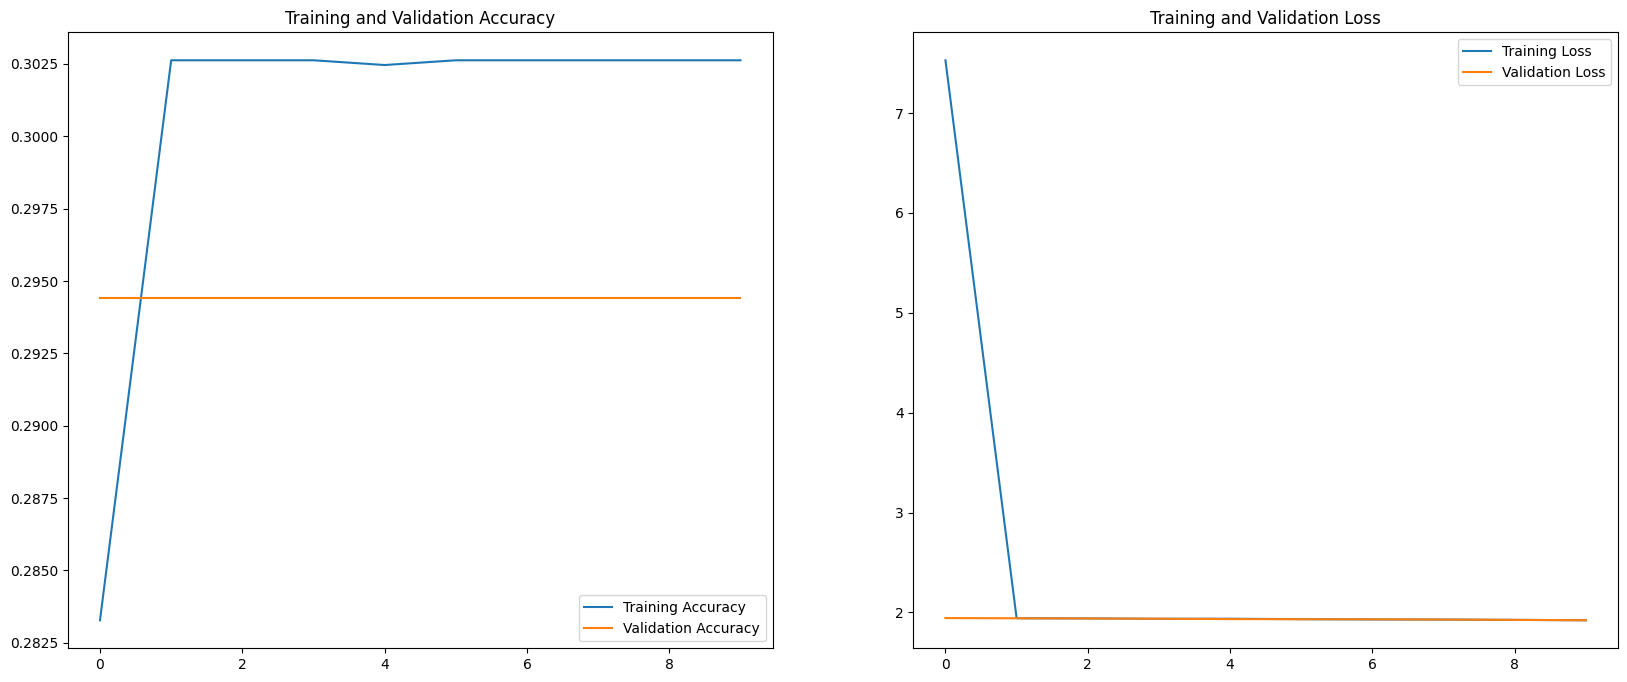

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
AUTOTUNE = tf.data.AUTOTUNE
test_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)


In [19]:
# Generate predictions
model.load_weights('best_model.weights.h5') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 655ms/step


In [20]:
model.evaluate(test_ds, verbose = 1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 594ms/step - accuracy: 0.2938 - loss: 1.9212


[1.9220621585845947, 0.29442623257637024]

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [21]:
# Define augmentation steps to augment images


Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [22]:
# Augmentation function
# Define augmentation using tf.keras.Sequential layers
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])


In [23]:
# Create the augmented training dataset

# Normalize
def normalize_image(image, label):
    image = tf.cast(image, tf.float32)
    return image, label

train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

print("✅ Datasets ready with Keras layers augmentation!")

✅ Datasets ready with Keras layers augmentation!


2025-04-22 18:48:52.392177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


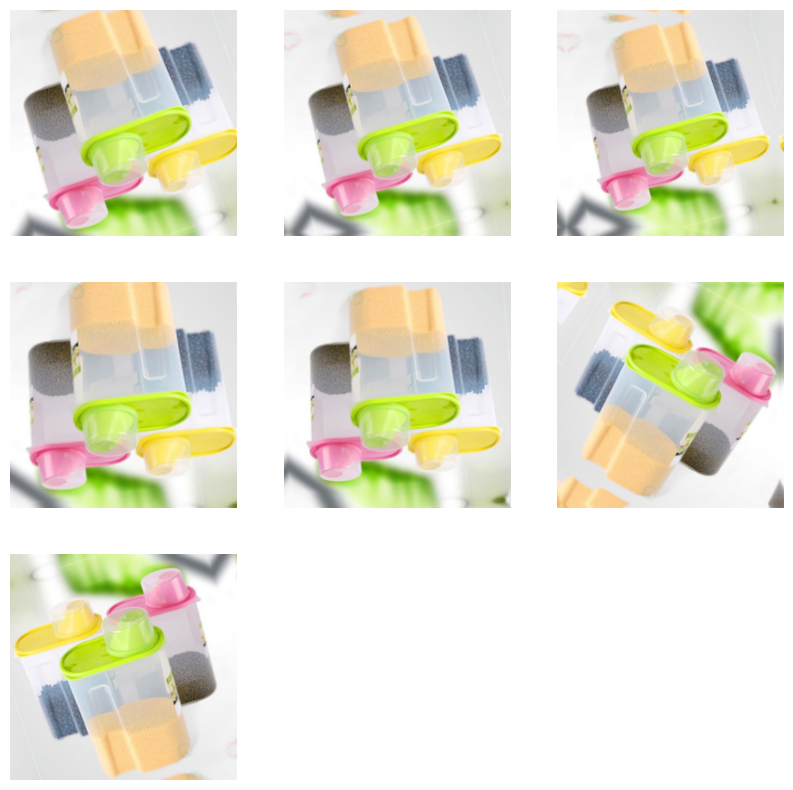

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
   # plt.title(class_names[2])
    plt.axis("off")

##### **4.1.2**

### Train the model on the new augmented dataset.


In [25]:
# Train the model using augmented images
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop, model_checkpoint, rop_callback]
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3021 - loss: 1.9236
Epoch 1: val_loss did not improve from 1.92206
96/96 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.3021 - loss: 1.9236 - val_accuracy: 0.2944 - val_loss: 1.9234 - learning_rate: 1.0000e-04
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2950 - loss: 1.9210
Epoch 2: val_loss improved from 1.92206 to 1.91990, saving model to best_model.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.2951 - loss: 1.9209 - val_accuracy: 0.2944 - val_loss: 1.9199 - learning_rate: 1.0000e-04
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3000 - loss: 1.9169
Epoch 3: val_loss improved from 1.91990 to 1.91755, saving model to best_model.weights.h5
96/96 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.3000 - loss: 1.9169 - val_accuracy: 0.2944 - val_loss: 1.9176 - learning_rate: 1.0000e-04
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3087 - loss: 1.9124
Epoch 4: 

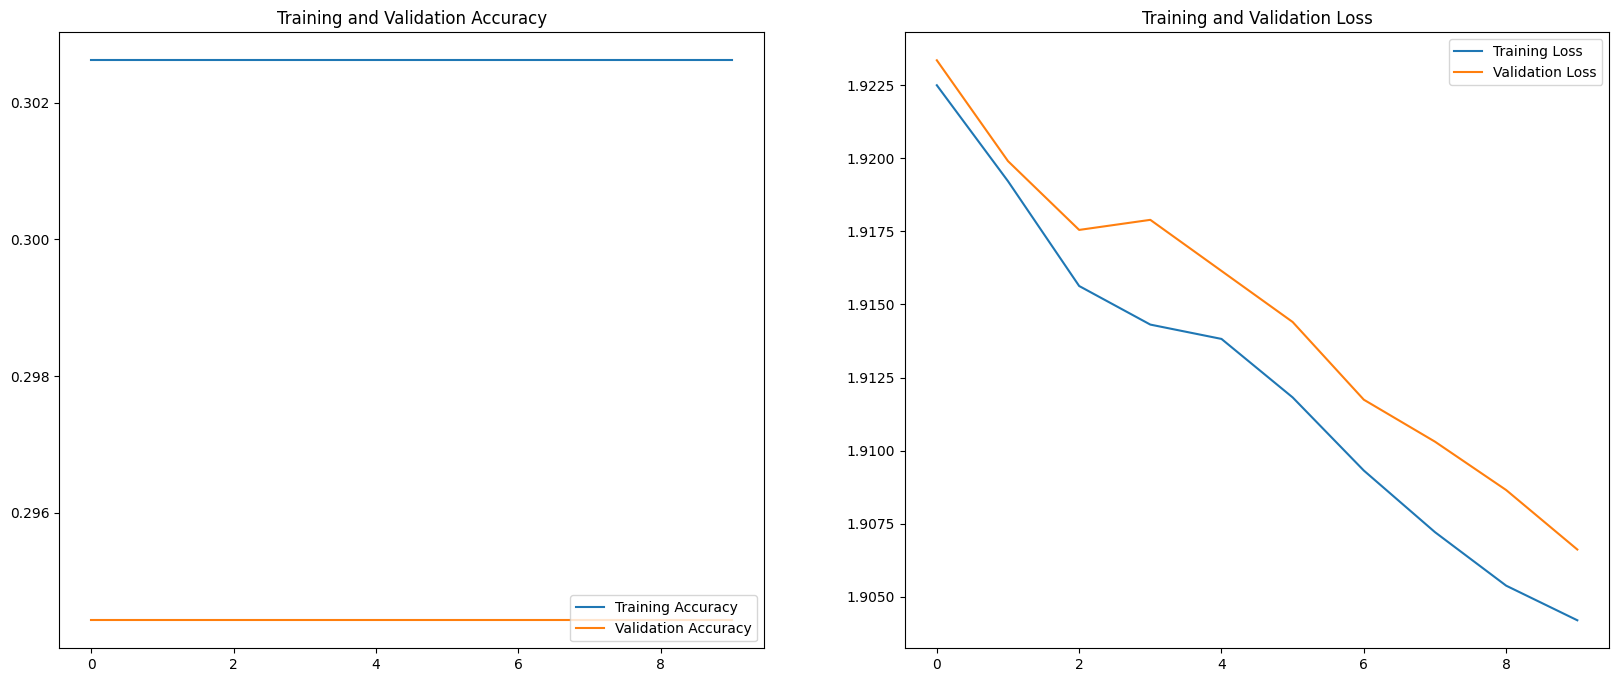

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
AUTOTUNE = tf.data.AUTOTUNE
test_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [28]:
# Generate predictions
model.load_weights('best_model.weights.h5') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 619ms/step


In [29]:
model.evaluate(test_ds, verbose = 1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 595ms/step - accuracy: 0.3087 - loss: 1.9053


[1.906620740890503, 0.29442623257637024]


## **Model Architecture** 

*   **VGG-16 Base Model**


In [30]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [31]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
#base_model.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 244, 244, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 244, 244, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 122, 122, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 122, 122, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 61, 61, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 61, 61, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 61, 61, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
def print_layer_trainable():
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [33]:
print_layer_trainable()

True:	input_layer_2
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


#### Let's fix the Weights 

In [34]:
base_model.trainable = False

In [35]:
for layer in base_model.layers:
    layer.trainable = False

In [36]:
print_layer_trainable()

False:	input_layer_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [37]:
n_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax')
])

### **Transfer Learning**

In [38]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (64, 244, 244, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (64, 244, 244, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (64, 7, 7, 512)        │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (64, 512)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (64, 128)              │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (64, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (64, 7)                │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,255 (56.39 MB)

 Trainable params: 66,567 (260.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [40]:
# ModelCheckpoint (final corrected)
model_chkpnt = ModelCheckpoint(
    filepath='vgg16_best.weights.h5',   # <-- this change here
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min'
)

# ReduceLROnPlateau
rop_callback = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.000001
)

In [41]:
%%time

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[model_chkpnt, early_stop, rop_callback]
)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1160s 12s/step - accuracy: 0.3038 - loss: 1.8707 - val_accuracy: 0.4761 - val_loss: 1.4388 - learning_rate: 0.0010
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1150s 12s/step - accuracy: 0.4708 - loss: 1.4470 - val_accuracy: 0.5462 - val_loss: 1.2370 - learning_rate: 0.0010
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1181s 12s/step - accuracy: 0.5078 - loss: 1.3207 - val_accuracy: 0.5908 - val_loss: 1.1493 - learning_rate: 0.0010
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1206s 13s/step - accuracy: 0.5463 - loss: 1.2439 - val_accuracy: 0.5961 - val_loss: 1.1065 - learning_rate: 0.0010
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1195s 12s/step - accuracy: 0.5661 - loss: 1.2143 - val_accuracy: 0.6131 - val_loss: 1.0488 - learning_rate: 0.0010
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1186s 12s/step - accuracy: 0.5876 - loss: 1.1583 - val_accuracy: 0.6334 - val_loss: 1.0242 - learning_rate: 0.0010
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1121s 12s/step - accuracy: 0.5983 - loss: 1.

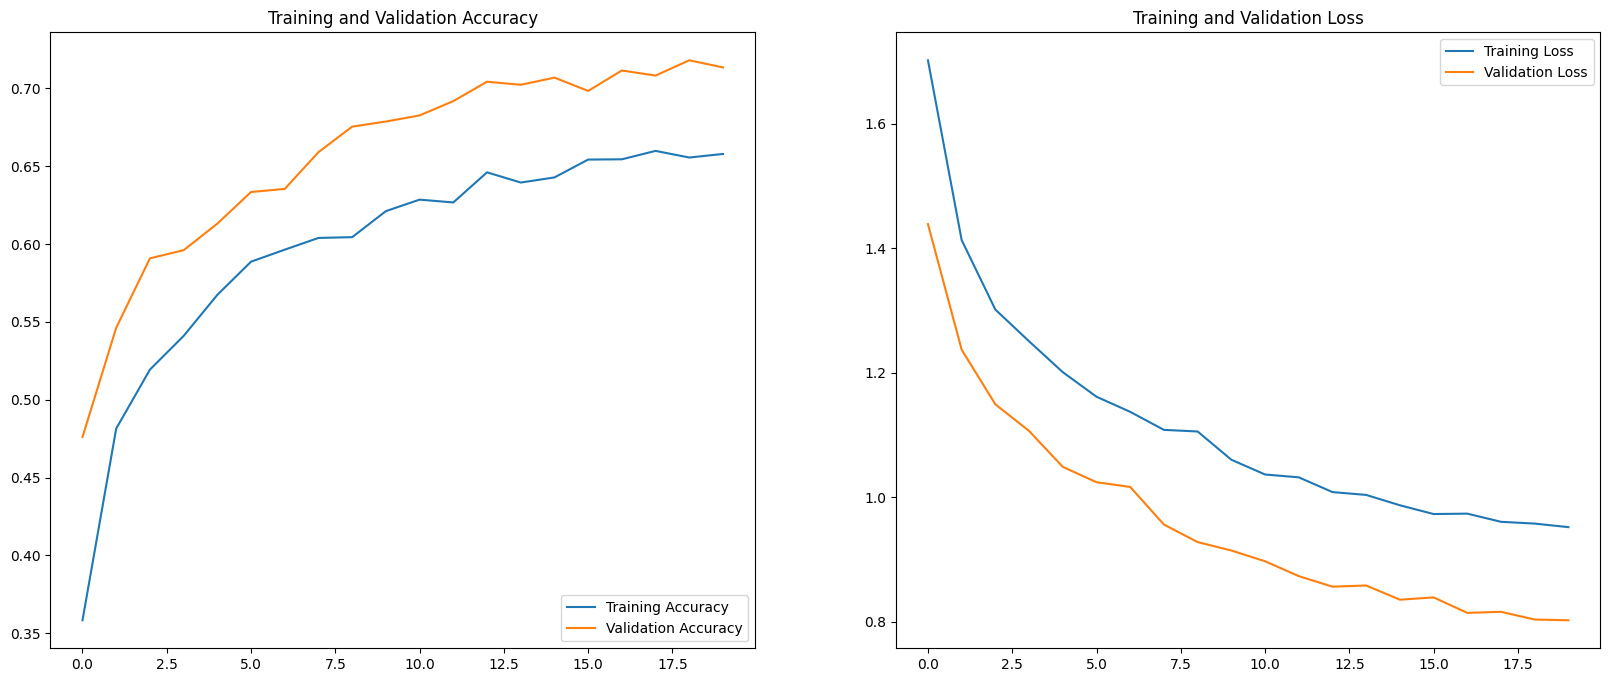

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
AUTOTUNE = tf.data.AUTOTUNE
test_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [44]:
# Generate predictions
model.load_weights('vgg16_best.weights.h5') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 207s 9s/step


In [45]:
model.evaluate(test_ds, verbose = 1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 205s 9s/step - accuracy: 0.7100 - loss: 0.8227


[0.8024486303329468, 0.7134426236152649]

### **Fine Tuning**

In [46]:
fine_tune  = base_model

In [47]:
fine_tune.trainable = True

In [48]:
for layer in fine_tune.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

In [49]:
print_layer_trainable()

False:	input_layer_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [50]:
fine_tune.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 244, 244, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 244, 244, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 122, 122, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 122, 122, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 61, 61, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 61, 61, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 61, 61, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [51]:
n_classes = len(class_names)

model2 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    fine_tune,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax')
])

In [52]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (64, 244, 244, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (64, 244, 244, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (64, 7, 7, 512)        │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (64, 512)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (64, 128)              │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (64, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (64, 7)                │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,255 (56.39 MB)

 Trainable params: 13,045,767 (49.77 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [53]:
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
# Model Chackpoint
model_chkpnt = ModelCheckpoint(filepath = 'vgg16_best_weights_fine_tuning_weights.h5', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)

In [55]:
%%time
history = model2.fit(train_ds,
                    epochs = EPOCHS,
                    validation_data = val_ds,
                    callbacks = [model_chkpnt, early_stop, rop_callback])

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.2383 - loss: 1.9426 

96/96 ━━━━━━━━━━━━━━━━━━━━ 1697s 18s/step - accuracy: 0.2389 - loss: 1.9411 - val_accuracy: 0.4157 - val_loss: 1.4678 - learning_rate: 1.0000e-05
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4536 - loss: 1.4857 

96/96 ━━━━━━━━━━━━━━━━━━━━ 1712s 18s/step - accuracy: 0.4539 - loss: 1.4850 - val_accuracy: 0.6210 - val_loss: 1.1340 - learning_rate: 1.0000e-05
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.5513 - loss: 1.2507 

96/96 ━━━━━━━━━━━━━━━━━━━━ 1703s 18s/step - accuracy: 0.5514 - loss: 1.2504 - val_accuracy: 0.6610 - val_loss: 0.9779 - learning_rate: 1.0000e-05
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6056 - loss: 1.1098 

96/96 ━━━━━━━━━━━━━━━━━━━━ 1706s 18s/step - accuracy: 0.6057 - loss: 1.1097 - val_accuracy: 0.6767 - val_loss: 0.9524 - learning_rate: 1.0000e-05
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6408 - loss: 1.0470 

96/96 ━━━━━━━━━━━━━━━━━━━━ 1697s 18s/step - accuracy: 0.6409 - loss: 1.0467 - val_accuracy: 0.6984 - val_loss: 0.8372 - learning_rate: 1.0000e-05
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.6681 - loss: 0.9646 

96/96 ━━━━━━━━━━━━━━━━━━━━ 1693s 18s/step - accuracy: 0.6682 - loss: 0.9645 - val_accuracy: 0.7187 - val_loss: 0.8297 - learning_rate: 1.0000e-05
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6830 - loss: 0.9056 

96/96 ━━━━━━━━━━━━━━━━━━━━ 1890s 20s/step - accuracy: 0.6829 - loss: 0.9058 - val_accuracy: 0.7285 - val_loss: 0.7933 - learning_rate: 1.0000e-05
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.6973 - loss: 0.8720 

96/96 ━━━━━━━━━━━━━━━━━━━━ 1727s 18s/step - accuracy: 0.6973 - loss: 0.8719 - val_accuracy: 0.7266 - val_loss: 0.7770 - learning_rate: 1.0000e-05
Epoch 9/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1776s 18s/step - accuracy: 0.7160 - loss: 0.8266 - val_accuracy: 0.7167 - val_loss: 0.8191 - learning_rate: 1.0000e-05
Epoch 10/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.7186 - loss: 0.8214 

96/96 ━━━━━━━━━━━━━━━━━━━━ 1834s 19s/step - accuracy: 0.7187 - loss: 0.8212 - val_accuracy: 0.7456 - val_loss: 0.7253 - learning_rate: 1.0000e-05
Epoch 11/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.7484 - loss: 0.7377 

96/96 ━━━━━━━━━━━━━━━━━━━━ 1714s 18s/step - accuracy: 0.7483 - loss: 0.7380 - val_accuracy: 0.7626 - val_loss: 0.6886 - learning_rate: 1.0000e-05
Epoch 12/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1720s 18s/step - accuracy: 0.7475 - loss: 0.7288 - val_accuracy: 0.7679 - val_loss: 0.6943 - learning_rate: 1.0000e-05
Epoch 13/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.7541 - loss: 0.7261 

96/96 ━━━━━━━━━━━━━━━━━━━━ 1791s 19s/step - accuracy: 0.7541 - loss: 0.7260 - val_accuracy: 0.7738 - val_loss: 0.6596 - learning_rate: 1.0000e-05
Epoch 14/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1817s 19s/step - accuracy: 0.7650 - loss: 0.6875 - val_accuracy: 0.7770 - val_loss: 0.6603 - learning_rate: 1.0000e-05
Epoch 15/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1671s 17s/step - accuracy: 0.7756 - loss: 0.6636 - val_accuracy: 0.7784 - val_loss: 0.6626 - learning_rate: 1.0000e-05
Epoch 16/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7867 - loss: 0.6195 

96/96 ━━━━━━━━━━━━━━━━━━━━ 2044s 21s/step - accuracy: 0.7867 - loss: 0.6196 - val_accuracy: 0.7862 - val_loss: 0.6299 - learning_rate: 1.0000e-05
Epoch 17/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.7998 - loss: 0.6031 

96/96 ━━━━━━━━━━━━━━━━━━━━ 2072s 22s/step - accuracy: 0.7997 - loss: 0.6033 - val_accuracy: 0.7928 - val_loss: 0.6061 - learning_rate: 1.0000e-05
Epoch 18/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 2302s 24s/step - accuracy: 0.8011 - loss: 0.6037 - val_accuracy: 0.7751 - val_loss: 0.6369 - learning_rate: 1.0000e-05
Epoch 19/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 2306s 24s/step - accuracy: 0.8104 - loss: 0.5649 - val_accuracy: 0.7948 - val_loss: 0.6183 - learning_rate: 1.0000e-05
Epoch 20/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.8086 - loss: 0.5529 
Epoch 20: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
96/96 ━━━━━━━━━━━━━━━━━━━━ 2436s 25s/step - accuracy: 0.8085 - loss: 0.5530 - val_accuracy: 0.7934 - val_loss: 0.6245 - learning_rate: 1.0000e-05
CPU times: user 3d 14h 42min 39s, sys: 5h 24min 32s, total: 3d 20h 7min 12s
Wall time: 10h 21min 50s


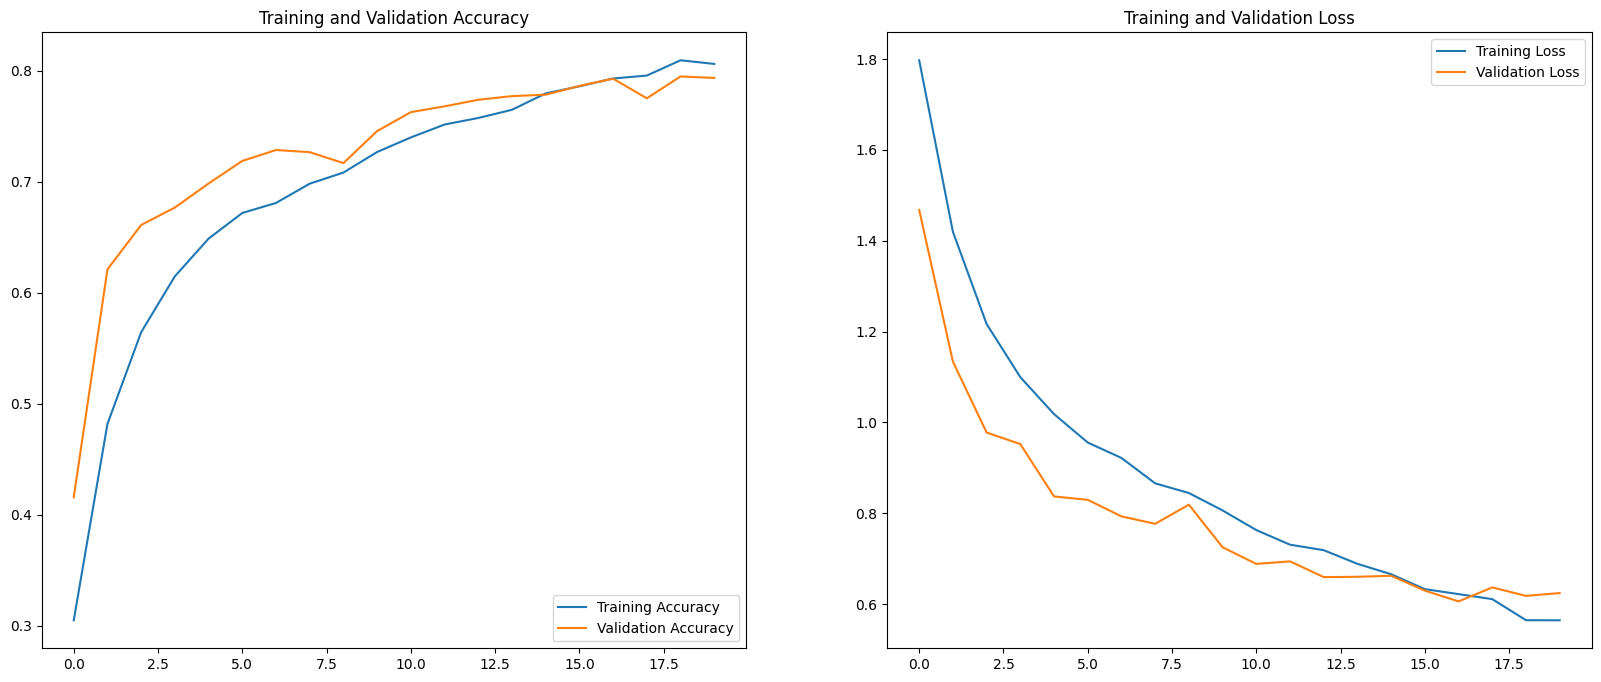

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [63]:
test_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [67]:
# Generate predictions
# Load only matching weights
model2.load_weights('vgg16_best_weights_fine_tuning_weights.h5')

# Then proceed
preds = model2.predict(test_ds)
pred_classes = np.argmax(preds, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 247s 10s/step


In [ ]:
model2.evaluate(test_ds, verbose = 1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 253s 11s/step - accuracy: 0.7937 - loss: 0.6008


[0.6061496138572693, 0.7927868962287903]

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results
 
    **Using VGG16**
    **Accuracy On Transfer Learning : 71.34%** </br>
    **Accuracy On Fine Tuning : 79.27%**</br>
